# Analysis part

In [19]:
library(ggplot2)
library(quantreg)


df = read.csv('merged_datasets_final/merged_Charizard___Holo_1999_Base_Set.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock to returns
df$adjclosestock_return <- c(NA, diff(log(df$adjclosestock)))

#remove rows with NA in the newly created return columns
df <- na.omit(df)

head(df)

,date,grade4price,grade5price,grade6price,grade7price,grade8price,grade9price,grade10price,adjclosestock,volume,...,bondadjusted,excessreturns,grade4price_return,grade5price_return,grade6price_return,grade7price_return,grade8price_return,grade9price_return,grade10price_return,adjclosestock_return
2,2016-10-01,26,50.00,38.000,41.0,65.5175,127.1250,775.0000,2126.15,72915530000,...,0.02589,-0.127730484,0,0.000000,0.0000000,-0.6991656,-0.29362652,-0.12813172,0.00000000,-0.0196168370
3,2016-11-01,26,50.00,43.670,34.0,63.6925,125.0000,775.0000,2198.81,88445380000,...,0.03017,-0.131140262,0,0.000000,0.1390752,-0.1872115,-0.02825047,-0.01685712,0.00000000,0.0336035450
4,2016-12-01,26,50.00,58.335,34.0,64.3500,189.4320,640.9950,2238.83,75344550000,...,0.03063,0.002953827,0,0.000000,0.2895409,0.0000000,0.01027012,0.41571638,-0.18984137,0.0180371113
5,2017-01-01,26,96.25,58.335,34.0,53.0000,105.0000,625.0000,2278.87,70576420000,...,0.03051,0.021802036,0,0.654926,0.0000000,0.0000000,-0.19404502,-0.59006977,-0.02527001,0.0177263146
6,2017-02-01,26,96.25,38.000,63.4,58.0540,114.7100,592.3333,2363.64,69260940000,...,0.02968,0.064402414,0,0.000000,-0.4286161,0.6231033,0.09108170,0.08844685,-0.05368211,0.0365230007
7,2017-03-01,26,96.25,38.000,48.0,55.0000,109.1825,704.5000,2362.72,81664010000,...,0.03018,-0.017235543,0,0.000000,0.0000000,-0.2782629,-0.05404043,-0.04938641,0.17341879,-0.0003892729


## Visualisation

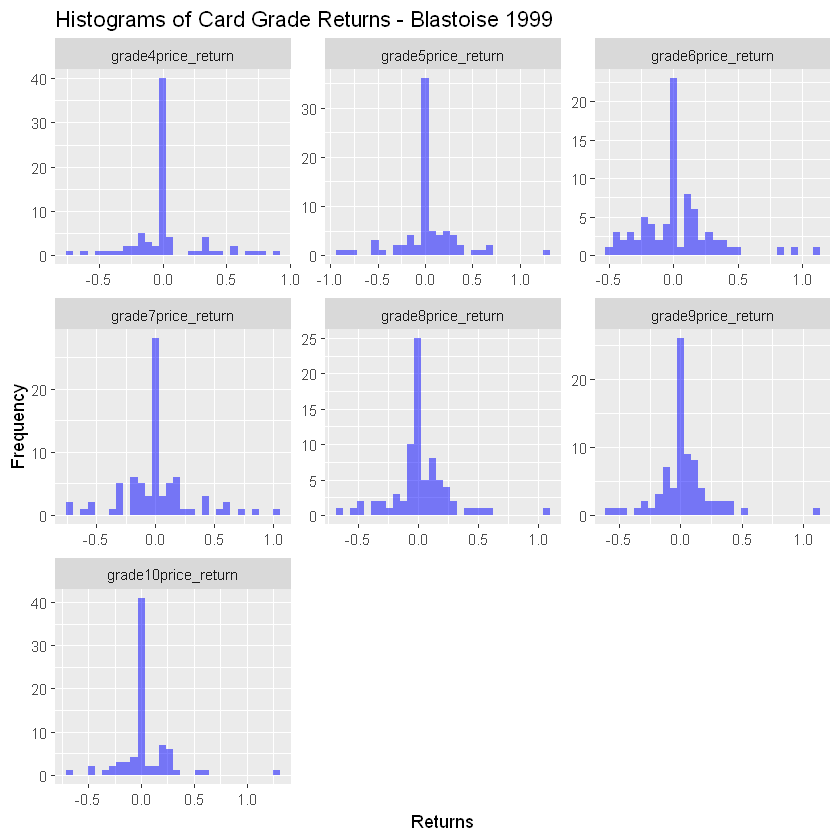

In [20]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

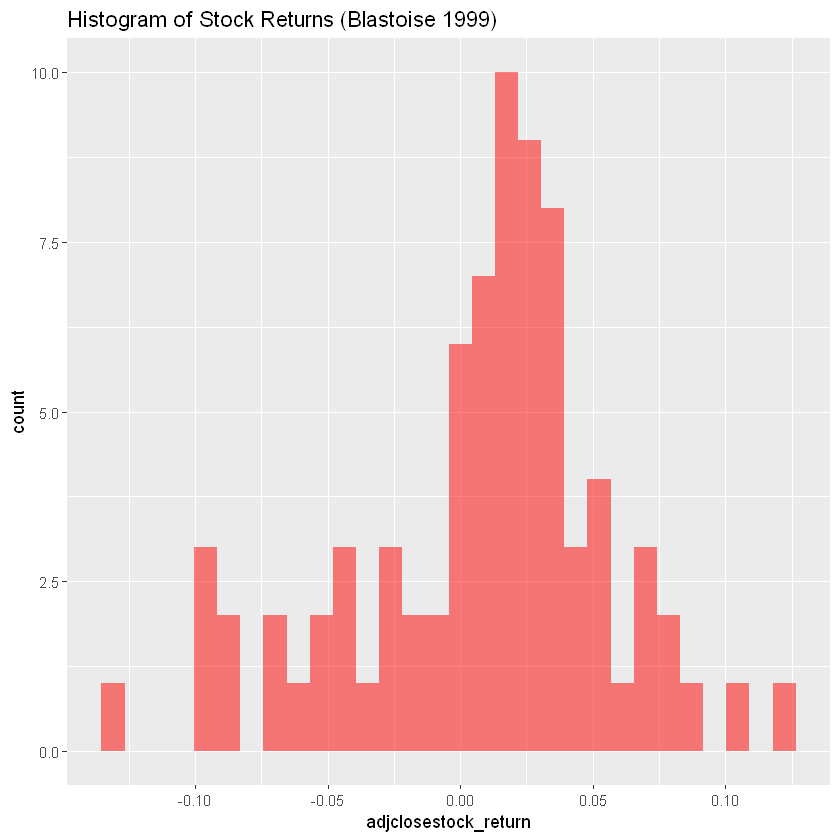

In [21]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

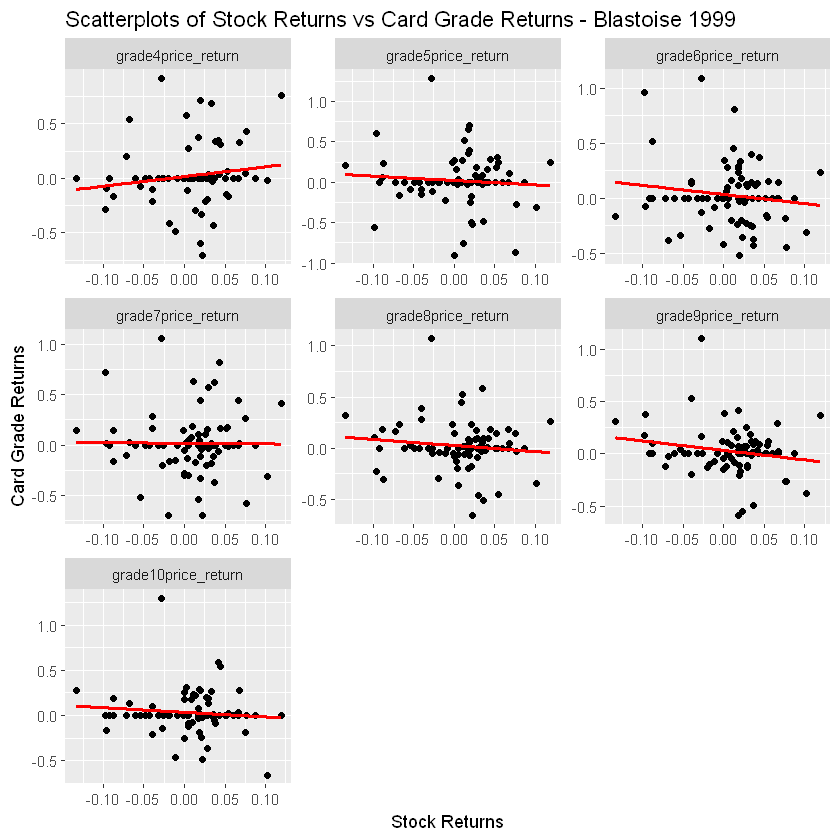

In [22]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestock_return"), measure.vars = grade_returns)

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestock_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Models

### OLS

In [23]:
#OLS
ols_models <- list()
for(grade_return in grade_returns) {
  ols_models[[grade_return]] <- lm(get(grade_return) ~ adjclosestock_return, data = df)
}

#print summary of each OLS model
for(grade_return in grade_returns) {
  print(paste("Summary of model for:", grade_return))
  print(summary(ols_models[[grade_return]]))
}


[1] "Summary of model for: grade4price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74378 -0.07440 -0.03077  0.01225  0.92262 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.01504    0.03150   0.477    0.635
adjclosestock_return  0.88852    0.64372   1.380    0.172

Residual standard error: 0.2743 on 76 degrees of freedom
Multiple R-squared:  0.02446,	Adjusted R-squared:  0.01162 
F-statistic: 1.905 on 1 and 76 DF,  p-value: 0.1715

[1] "Summary of model for: grade5price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.92692 -0.05291 -0.01139  0.11702  1.24253 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.02183    0.03664   0.596    0.553
adjclosestock_return -0.53794    0.74862  -0.719    0.475

Re

### Quantile regression

In [24]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = 0.1)  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  print(paste("Summary of quantile regression model for:", grade_return))
  print(summary(quantile_models[[grade_return]]))
}


[1] "Summary of quantile regression model for: grade4price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.22776     -0.43945 -0.18505
adjclosestock_return  0.57133     -1.56650  3.71935
[1] "Summary of quantile regression model for: grade5price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.23328     -0.52846 -0.16755
adjclosestock_return -0.82211     -4.38974  1.42312
[1] "Summary of quantile regression model for: grade6price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.32661     -0.41407 -0.23746
adjclosestock_return -1.16699

In [25]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step

#### Results for different quantiles of the grade prices x OLS estimates (red line) 

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

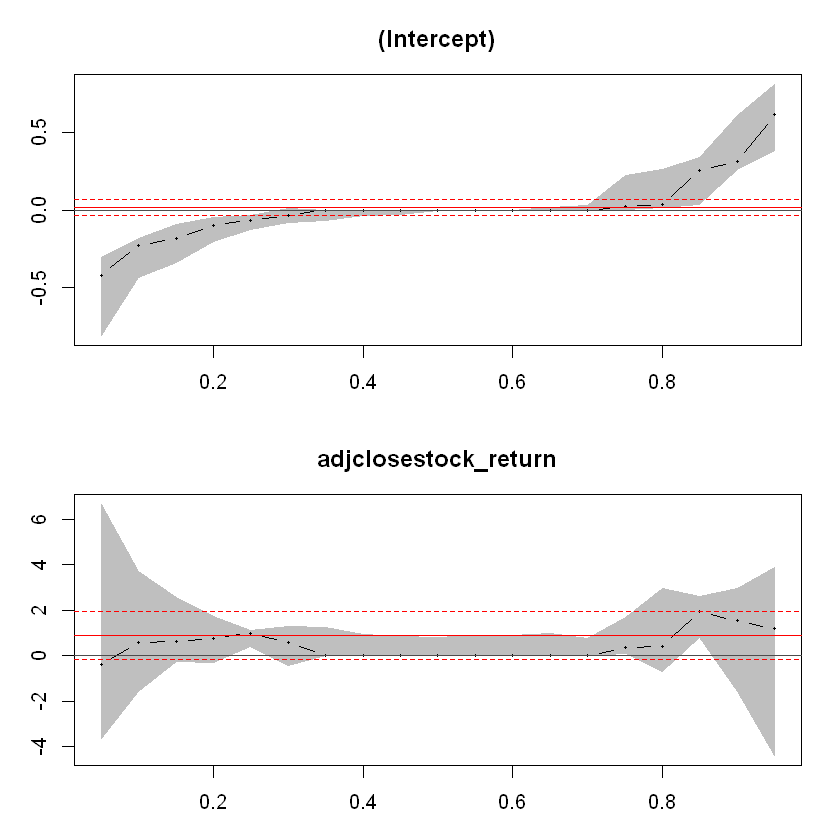

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

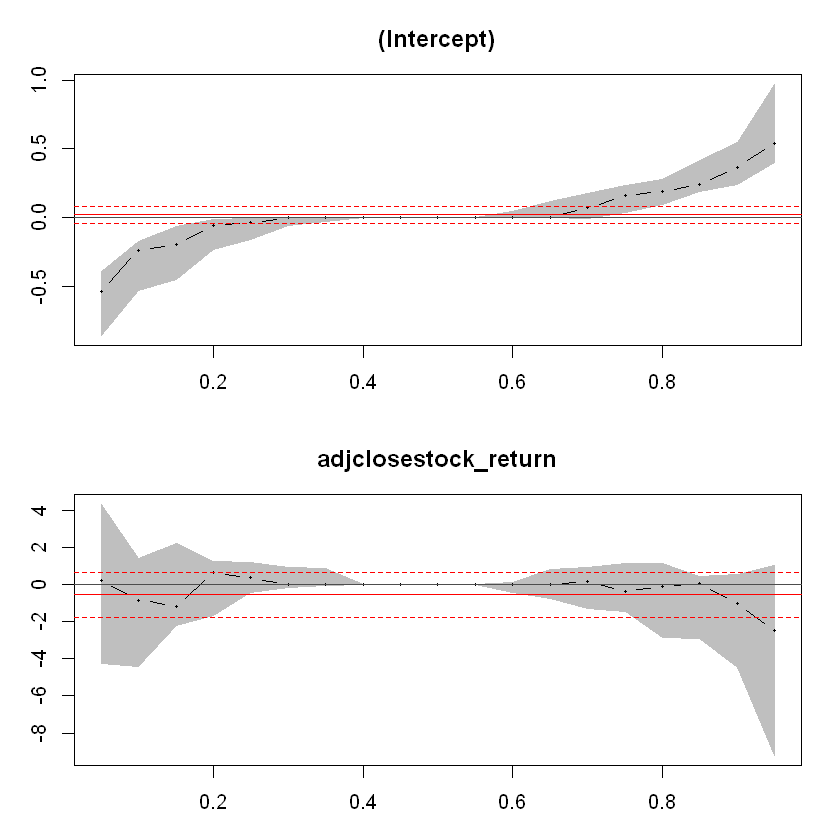

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

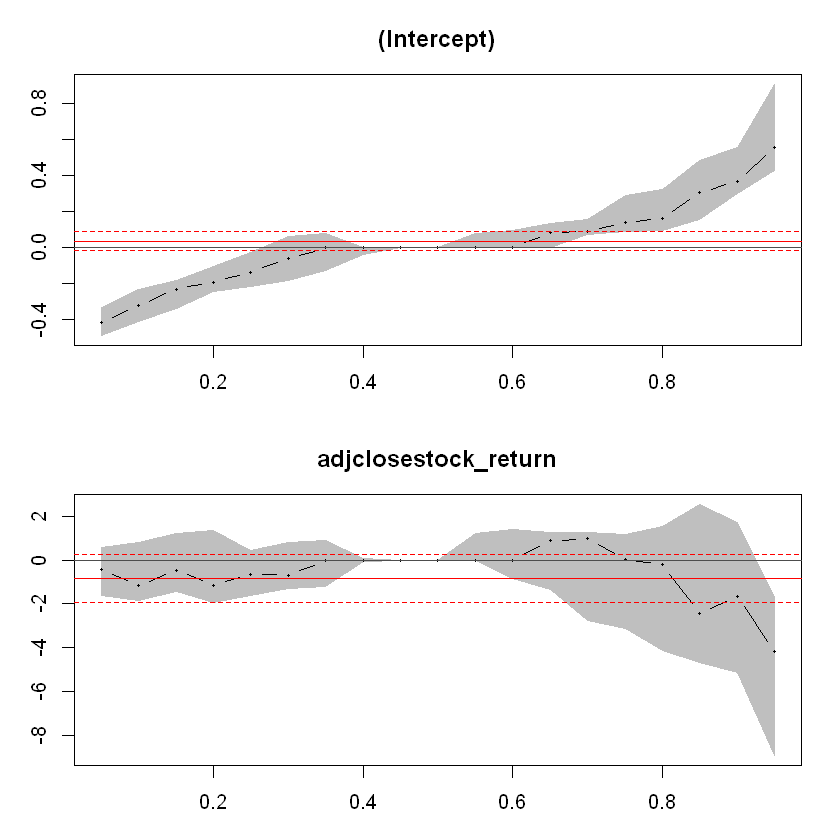

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

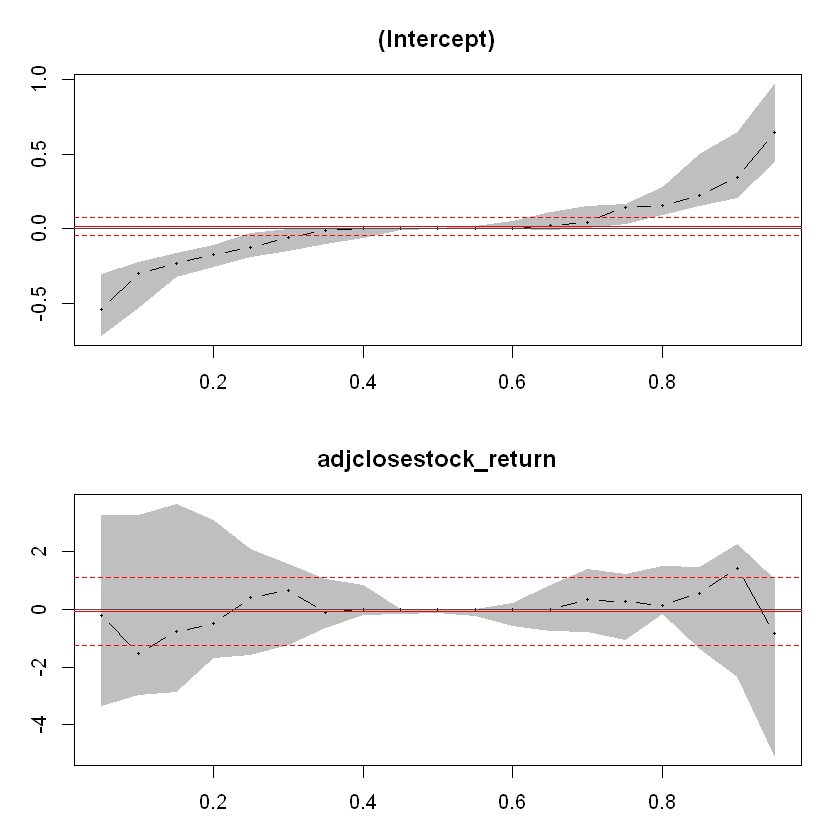

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

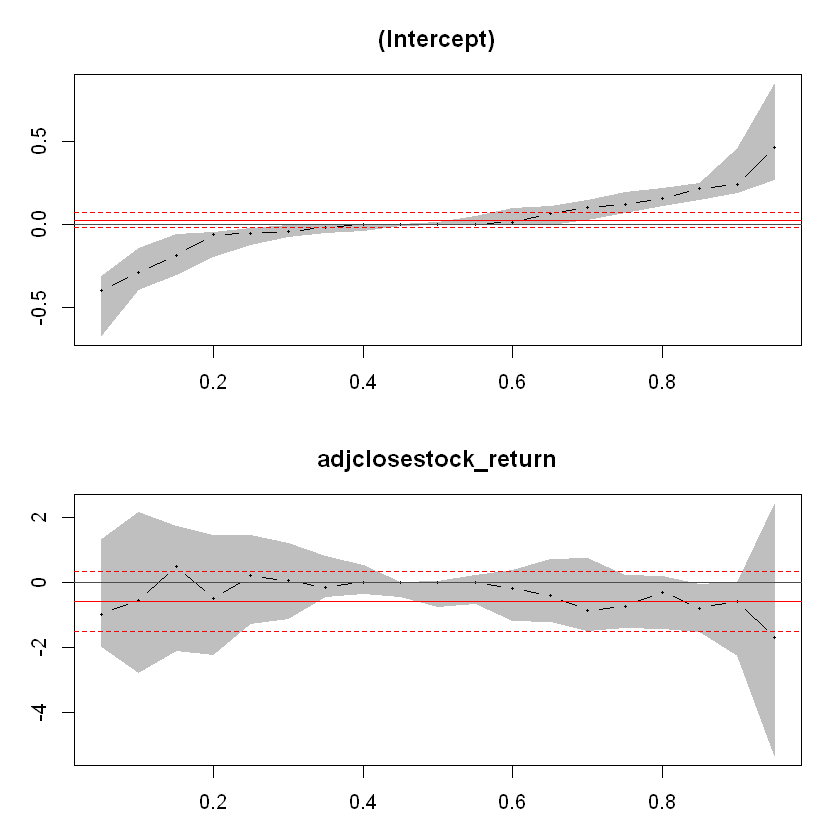

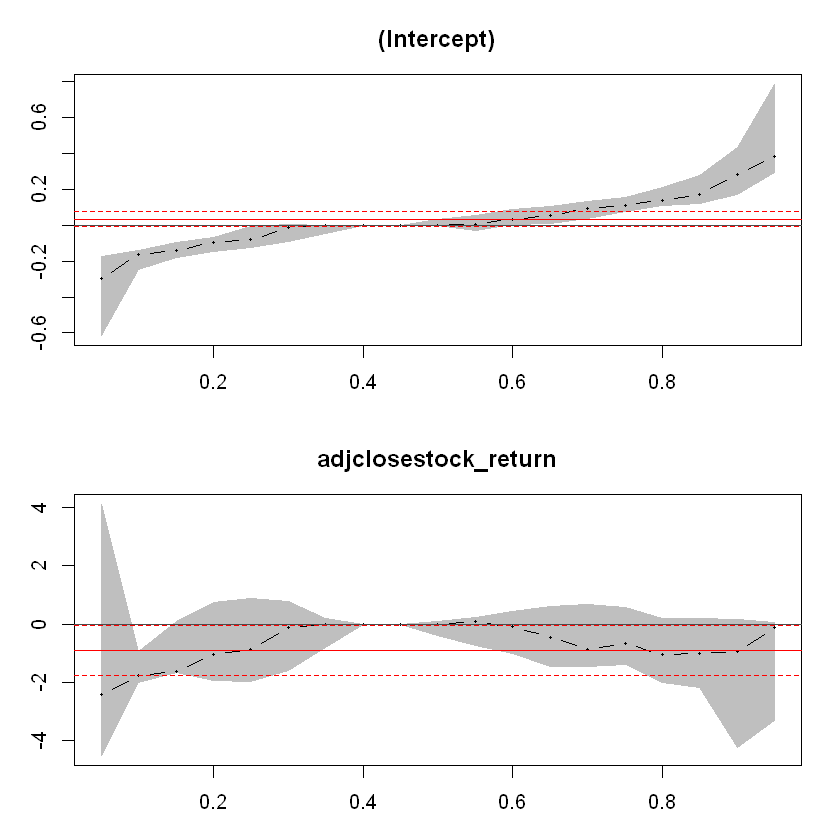

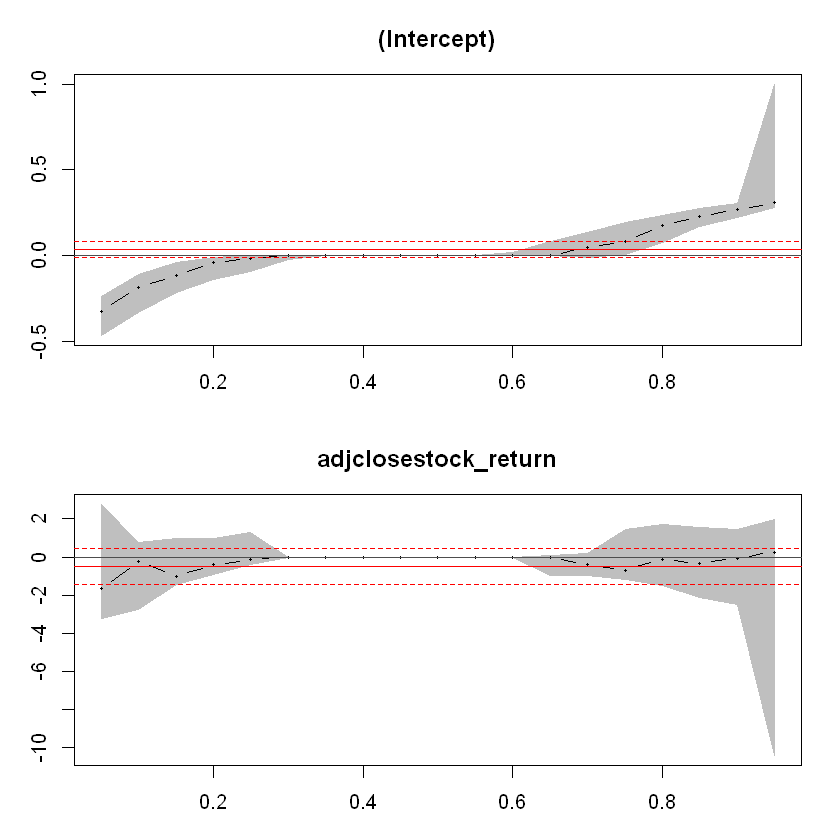

In [26]:

for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
  plot(summary(quantile_models[[grade_return]]))
}